# A simple GAN to generate samples from Gaussian distribution (minibatch)
References:
1. https://github.com/togheppi/vanilla_GAN
2. https://github.com/ericjang/genadv_tutorial/blob/master/genadv1.ipynb
3. https://machinelearningmastery.com/how-to-develop-a-generative-adversarial-network-for-a-1-dimensional-function-from-scratch-in-keras/
4. https://blog.aylien.com/introduction-generative-adversarial-networks-code-tensorflow/
5. https://github.com/kremerj/gan
6. https://github.com/igul222/improved_wgan_training
7. https://github.com/AYLIEN/gan-intro/blob/master/gan.py

In [43]:
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.stats import norm
import torch
import torch.nn as nn
from torch.autograd import Variable

## Understand target distribution: Gaussian distribution

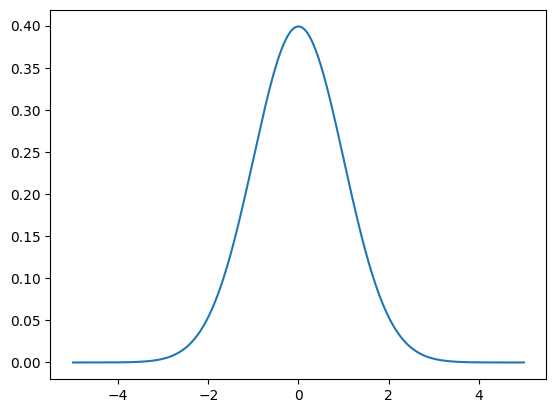

In [44]:
mu,sigma = 0,1
num_samples = 1000
xs = np.linspace(-5, 5, num_samples) # interval = 10/1000=0.01
samples = norm.pdf(xs, mu, sigma)
plt.plot(xs, samples)

## Classes for data sampling

In [45]:
# Real data distribution
class RealDistribution:
    def __init__(self, mu, sigma):
        self.mu = mu
        self.sigma = sigma

    def sample(self, num_samples):
        samples = np.random.normal(self.mu, self.sigma, num_samples)
        samples.sort()

        return samples

# Noise data distribution as inputs for the generator
class NoiseDistribution:
    def __init__(self, data_range):
        self.data_range = data_range

    def sample(self, num_samples):
        offset = np.random.random(num_samples)*0.01 # Random floats with uniform dist. in the interval [0.0, 0.01)
        samples = np.linspace(-self.data_range, self.data_range, num_samples) + offset

        return samples

## Generator

In [46]:
def linear(input_dim, output_dim):
    fc = nn.Linear(input_dim, output_dim, bias=True)
    # initializer
    nn.init.normal_(fc.weight, std=1.0)
    nn.init.constant_(fc.bias, 0.0)

    return nn.Sequential(fc, nn.ReLU())


class Generator(nn.Module):     # 1->32->1
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(Generator, self).__init__()
        # Hidden layer
        self.hidden_layer = linear(input_dim, hidden_dim)
        fc = nn.Linear(hidden_dim, output_dim, bias=True)
        # initializer
        nn.init.normal_(fc.weight, std=1.0)
        nn.init.constant_(fc.bias, 0.0)
        # Output layer
        #self.output_layer = nn.Sequential(fc, nn.Tanh())
        self.output_layer = nn.Sequential(fc)

    def forward(self, x):
        h = self.hidden_layer(x)
        out = self.output_layer(h)

        return out

## Discriminator

In [47]:
def minibatch(input, num_kernels=8, kernel_dim=3):
    x = nn.Linear(input.size()[1], num_kernels * kernel_dim, bias=True)(input)
    activation = x.view(-1, num_kernels, kernel_dim)
    diffs = activation.unsqueeze(3) - activation.permute(1, 2, 0).unsqueeze(0)
    abs_diffs = torch.sum(torch.abs(diffs), dim=2)
    minibatch_features = torch.sum(torch.exp(-abs_diffs), dim=2)

    return torch.cat((input, minibatch_features), 1)

class Discriminator(nn.Module): # 1->32->1
    def __init__(self, input_dim, hidden_dim, output_dim, minibatch=False):
        super(Discriminator, self).__init__()

        self.minib = minibatch
        if not self.minib:
            self.hidden_layer = linear(input_dim, hidden_dim)
        else:
            self.hidden_layer = linear(input_dim, int(3*hidden_dim/4))

        # Output layer
        fc = nn.Linear(hidden_dim, output_dim, bias=True)
        nn.init.normal_(fc.weight, std=1.0)
        nn.init.constant_(fc.bias, 0.0)
        self.output_layer = nn.Sequential(fc, nn.Sigmoid())

    def forward(self, x):
        h = self.hidden_layer(x)

        if self.minib:
            h = minibatch(h, num_kernels=8, kernel_dim=3)

        out = self.output_layer(h)

        return out

## TestSample class

In [48]:
# Test samples
class TestSample:
    def __init__(self, discriminator, generator, realD, data_range, batch_size, num_samples, num_bins):
        self.D = discriminator
        self.G = generator
        self.realD = realD
        self.bs = batch_size
        self.num_samples = num_samples
        self.num_bins = num_bins
        self.xs = np.linspace(-data_range, data_range, num_samples)
        self.bins = np.linspace(-data_range, data_range, num_bins)

    def decision_boundary(self):
        db = np.zeros((self.num_samples, 1))
        for i in range(self.num_samples // self.bs):
            x_ = self.xs[self.bs*i:self.bs*(i+1)]
            x_ = Variable(torch.FloatTensor(np.reshape(x_, [self.bs, 1])))

            db[self.bs*i:self.bs*(i+1)] = self.D(x_).detach().numpy()

        return db

    def real_distribution(self):
        d = self.realD.sample(self.num_samples)
        p_data, _ = np.histogram(d, self.bins, density=True)

        return p_data

    def gen_distribution(self):
        zs = self.xs
        g = np.zeros((self.num_samples, 1))
        for i in range(self.num_samples // self.bs):
            z_ = zs[self.bs*i:self.bs*(i+1)]
            z_ = Variable(torch.FloatTensor(np.reshape(z_, [self.bs, 1])))
            g[self.bs*i:self.bs*(i+1)] = self.G(z_).detach().numpy()

        p_gen, _ = np.histogram(g, self.bins, density=True)

        return p_gen

## Display class

In [49]:
class Display:
    def __init__(self, num_samples, num_bins, data_range, mu, sigma):
        self.num_samples = num_samples
        self.num_bins = num_bins
        self.data_range = data_range
        self.mu = mu
        self.sigma = sigma

    def plot_result(self, db_pre_trained, db_trained, p_data, p_gen):
        d_x = np.linspace(-self.data_range, self.data_range, len(db_trained))
        p_x = np.linspace(-self.data_range, self.data_range, len(p_data))

        f, ax = plt.subplots(1)
        #ax.plot(d_x, db_pre_trained, '--', label='Decision boundary (pre-trained)')
        ax.plot(d_x, db_trained, label='Decision boundary')
        ax.set_ylim(0, max(1, np.max(p_data)*2.0))
        ax.set_xlim(self.mu-self.data_range*1.0, self.mu+self.data_range*1.0)
        plt.plot(p_x, p_data, label='Real data')
        plt.plot(p_x, p_gen, label='Generated data')
        plt.title('Gaussian Approximation using GAN: ' + '(mu: %3g,' % self.mu + ' sigma: %3g)' % self.sigma)
        plt.xlabel('Data values')
        plt.ylabel('Probability density')
        plt.legend(loc=1)
        plt.grid(True)

        # Save plot
        #save_dir = "result/"
        #if not os.path.exists(save_dir):
        #    os.mkdir(save_dir)
        #plt.savefig(save_dir + '1D_Gaussian' + '_mu_%g' % self.mu + '_sigma_%g' % self.sigma + '.png')

        plt.show()

## Pretrain discriminator

In [50]:
# Hyper-parameters
mu = 0.0
sigma = 1.0
data_range = 5
batch_size = 10

input_dim = 1
hidden_dim = 32
output_dim = 1
num_epochs = 5000
num_epochs_pre = 5000
learning_rate = 0.001

In [51]:
# Samples
realData = RealDistribution(mu, sigma)     # via np.random.normal
noiseData = NoiseDistribution(data_range)  # unfiorm plus some variations

# Create models
G = Generator(input_dim, hidden_dim, output_dim)
D = Discriminator(input_dim, hidden_dim, output_dim, True)
#D = Discriminator(input_dim, hidden_dim, output_dim)

# Save intialized models
#torch.save(G.state_dict(), './SavedModel/Gini.pt')
#torch.save(D.state_dict(), './SavedModel/Dini.pt')
#G.load_state_dict(torch.load('./SavedModel/Gini.pt'))
#G.train()
#D.load_state_dict(torch.load('./SavedModel/Dini.pt'))
#D.train()

# Loss function (MSE loss)
#pre_criterion = nn.MSELoss()
pre_criterion = nn.BCELoss()

# optimizer
optimizer = torch.optim.SGD(D.parameters(), lr=learning_rate)

# Print model's state_dict
print("Generator's state_dict:")
for param_tensor in G.state_dict():
    print(param_tensor, "\t", G.state_dict()[param_tensor].size())

print("Discriminator's state_dict:")
for param_tensor in D.state_dict():
    print(param_tensor, "\t", D.state_dict()[param_tensor].size())

# Print optimizer's state_dict
print("Optimizer's state_dict:")
for var_name in optimizer.state_dict():
    print(var_name, "\t", optimizer.state_dict()[var_name])

Generator's state_dict:
hidden_layer.0.weight 	 torch.Size([32, 1])
hidden_layer.0.bias 	 torch.Size([32])
output_layer.0.weight 	 torch.Size([1, 32])
output_layer.0.bias 	 torch.Size([1])
Discriminator's state_dict:
hidden_layer.0.weight 	 torch.Size([24, 1])
hidden_layer.0.bias 	 torch.Size([24])
output_layer.0.weight 	 torch.Size([1, 32])
output_layer.0.bias 	 torch.Size([1])
Optimizer's state_dict:
state 	 {}
param_groups 	 [{'lr': 0.001, 'momentum': 0, 'dampening': 0, 'weight_decay': 0, 'nesterov': False, 'maximize': False, 'foreach': None, 'differentiable': False, 'params': [0, 1, 2, 3]}]


Streaming output truncated to the last 5000 lines.
        [7.9924e-26],
        [3.5603e-26],
        [1.6378e-26],
        [7.9115e-27],
        [4.0104e-27],
        [2.1516e-27],
        [1.2111e-27],
        [7.2147e-28],
        [4.5453e-28],
        [3.0358e-28],
        [2.1388e-28],
        [1.6012e-28],
        [1.2724e-28],
        [1.0786e-28],
        [9.6459e-29],
        [9.1433e-29],
        [9.1909e-29],
        [9.8981e-29],
        [1.1286e-28],
        [1.3664e-28],
        [1.7593e-28],
        [2.4249e-28],
        [3.5976e-28],
        [5.7073e-28],
        [9.6441e-28],
        [1.7398e-27],
        [3.3639e-27],
        [6.9284e-27],
        [1.5190e-26],
        [3.5307e-26],
        [8.7894e-26],
        [2.3263e-25],
        [6.5511e-25],
        [1.9674e-24],
        [6.3237e-24],
        [2.1730e-23],
        [7.9841e-23],
        [3.1327e-22],
        [1.3267e-21],
        [6.0863e-21],
        [3.0070e-20],
        [1.6067e-19],
        [9.3090e-19],
   

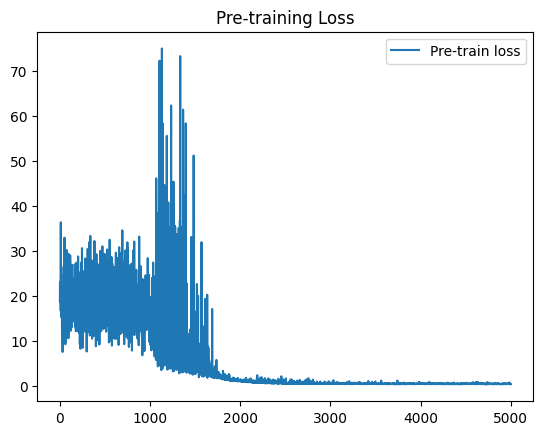

In [52]:
num_samples_pre = 1000
num_bins_pre = 100 # number of equal-width bins in a histogram
D_pre_losses = []
for epoch in range(num_epochs_pre):
    # Generate samples
    real = realData.sample(num_samples_pre)
    histc, edges = np.histogram(real, num_bins_pre, density=True)

    # Estimate pdf
    max_histc = np.max(histc)
    min_histc = np.min(histc)
    y_ = (histc - min_histc) / (max_histc - min_histc)  # normalize y_ to range [0,1]
    #print('len of y_: ', len(y_), ', y_: ', y_)
    x_ = edges[1:]

    x_ = Variable(torch.FloatTensor(np.reshape(x_, [num_bins_pre, input_dim])))
    y_ = Variable(torch.FloatTensor(np.reshape(y_, [num_bins_pre, output_dim])))
    #print(y_)

    # Train D model
    optimizer.zero_grad()
    D_pre_decision = D(x_)
    D_pre_loss = pre_criterion(D_pre_decision, y_)
    #D_pre_loss = torch.mean(-torch.log(D_pre_decision)-torch.log(1.-y_))
    D_pre_loss.backward()
    optimizer.step()

    # Save loss values for plot
    D_pre_losses.append(D_pre_loss.item())

    if epoch % 100 == 0:
        print(D_pre_decision)
        print(epoch, D_pre_loss.item())
    #print(epoch, D_pre_loss.item())

# Plot loss
fig, ax = plt.subplots()
losses = np.array(D_pre_losses)
plt.plot(losses, label='Pre-train loss')
plt.title("Pre-training Loss")
plt.legend()
plt.show()

In [53]:
# Test sample after pre-training (to be drawn later)
num_samples = 10000
num_bins = 100
sample = TestSample(D, G, realData, data_range, batch_size, num_samples, num_bins)
db_pre_trained = sample.decision_boundary()

## Train GAN

In [54]:
# Optimizers
D_optimizer = torch.optim.SGD(D.parameters(), lr=learning_rate)
G_optimizer = torch.optim.SGD(G.parameters(), lr=learning_rate)

D_losses = []
G_losses = []
for epoch in range(num_epochs):
    # Generate samples
    x_ = realData.sample(batch_size)
    x_ = Variable(torch.FloatTensor(np.reshape(x_, [batch_size, input_dim])))
    y_real_ = Variable(torch.ones([batch_size, output_dim]))
    y_fake_ = Variable(torch.zeros([batch_size, output_dim]))

    # Train discriminator with real data
    D_real_decision = D(x_)
    #D_real_loss = criterion(D_real_decision, y_real_)

    # Train discriminator with fake data
    z_ = noiseData.sample(batch_size)
    z_ = Variable(torch.FloatTensor(np.reshape(z_, [batch_size, input_dim])))
    z_ = G(z_)

    D_fake_decision = D(z_)
    #D_fake_loss = criterion(D_fake_decision, y_fake_)

    # Back propagation
    #D_loss = D_real_loss + D_fake_loss
    D_loss = torch.mean(-torch.log(D_real_decision)-torch.log(1.-D_fake_decision))
    D.zero_grad()
    D_loss.backward()
    D_optimizer.step()

    # Train generator
    z_ = noiseData.sample(batch_size)
    z_ = Variable(torch.FloatTensor(np.reshape(z_, [batch_size, input_dim])))
    z_ = G(z_)

    D_fake_decision = D(z_)
    #G_loss = criterion(D_fake_decision, y_real_) # note that we put y_real_ here
    G_loss = torch.mean(-torch.log(D_fake_decision))

    # Back propagation
    D.zero_grad()
    G.zero_grad()
    G_loss.backward()
    G_optimizer.step()

    # Save loss values for plot
    D_losses.append(D_loss.item())
    G_losses.append(G_loss.item())
    #print(D_losses)

    if epoch % 100 == 0:
        print('epoch:{}, D loss:{}, G loss:{}'.format(epoch, D_loss.item(), G_loss.item()))

epoch:0, D loss:1.0499374866485596, G loss:10.776433944702148
epoch:100, D loss:1.953070878982544, G loss:0.8307479619979858
epoch:200, D loss:1.683047890663147, G loss:0.9082521200180054
epoch:300, D loss:1.478494644165039, G loss:0.7780522108078003
epoch:400, D loss:1.3934690952301025, G loss:0.8273857235908508
epoch:500, D loss:1.3741767406463623, G loss:0.6749467253684998
epoch:600, D loss:1.3997626304626465, G loss:0.7262444496154785
epoch:700, D loss:1.353301763534546, G loss:0.72954261302948
epoch:800, D loss:1.3470605611801147, G loss:0.6945089101791382
epoch:900, D loss:1.3869096040725708, G loss:0.6770774126052856
epoch:1000, D loss:1.4214982986450195, G loss:0.6420340538024902
epoch:1100, D loss:1.3844949007034302, G loss:0.6959664225578308
epoch:1200, D loss:1.4352385997772217, G loss:0.666791558265686
epoch:1300, D loss:1.3995684385299683, G loss:0.6686489582061768
epoch:1400, D loss:1.4475150108337402, G loss:0.7220131754875183
epoch:1500, D loss:1.3746473789215088, G los

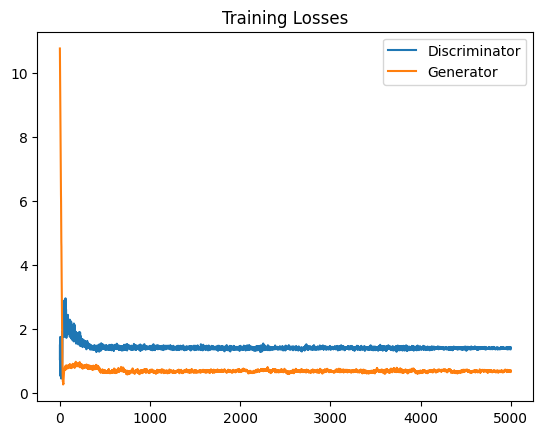

In [55]:
# Plot losses
fig, ax = plt.subplots()
D_losses = np.array(D_losses)
G_losses = np.array(G_losses)
plt.plot(D_losses, label='Discriminator')
plt.plot(G_losses, label='Generator')
plt.title("Training Losses")
plt.legend()
plt.show()

## Evaluation

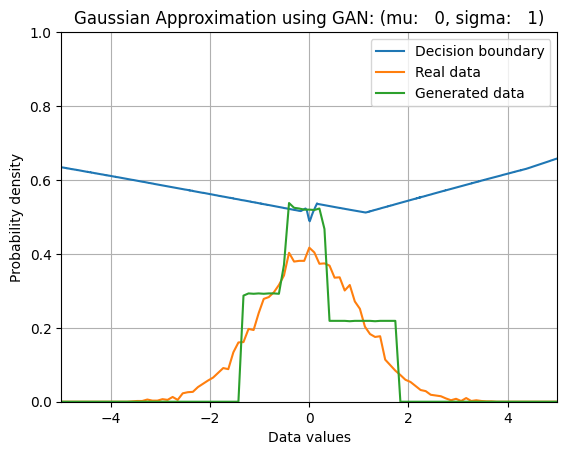

In [56]:
# Test sample after GAN-training
sample = TestSample(D, G, realData, data_range, batch_size, num_samples, num_bins)
db_trained = sample.decision_boundary()
p_data = sample.real_distribution()
p_gen = sample.gen_distribution()

# Display result
display = Display(num_samples, num_bins, data_range, mu, sigma)
display.plot_result(db_pre_trained, db_trained, p_data, p_gen)